In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

#from trading_system_copy import TradingSystem
#from trading_optimization_copy import OptimizeTradingSystem

from trading_system import TradingSystem as TradingSystem



In [2]:
cointegration_params = {
    "validation_size": 250,
    "test_size": 250,
    "strategy": "cointegration",
    "cointegration_rolling_window": 250
}

forecasting_params = {
    "strategy": "forecasting",
    "validation_size": 250,
    "test_size": 250,
}

cointegration_study_params = {
    "rolling_window_range": [5,60,5],
    "lower_threshold_range": [0.0,2.0,0.01],
}

forecasting_study_params = {
    "rolling_window_range": [5,60,5],
    "lower_threshold_range": [0.0,2.0,0.01],
}

validation_size = 250
test_size = 250
window_size = 5
model = "ann_long"
#models = ["arima", "ann", "vecm", "tvecm_long_t1", "ols", "naive", "perfect_information"]
models = ["arima", "ann", "vecm", "tvecm_long_t1", "ols"]
pairs = ["ttf-the", "ttf-nbp", "the-nbp"]
window_sizes = [5]
volatility_models = ["rolling", "sGARCH_norm","sGARCH_sstd", "fiGARCH_sstd", "gjrGARCH_sstd", "sGARCH_norm_21", "sGARCH_sstd_21",  "gjrGARCH_sstd_21"]
#volatility_models = ["rolling"]

df = pd.DataFrame()

for model in models:
    for window_size in window_sizes:
        for pair in pairs:
            for vol_model in volatility_models:

                hub1_name = pair.split("-")[0]
                hub2_name = pair.split("-")[1]

                params = cointegration_params if model == "ols" else forecasting_params
                study_params = cointegration_study_params if model == "ols" else forecasting_study_params

                
                params["hub1_name"] = hub1_name
                params["hub2_name"] = hub2_name
                params["model"] = model
                params["window_size"] = window_size

                study_params["volatility"] = vol_model
                study_params["criteria"] = "mean_returns"
                study_params["min_trades"] = 10
                study_params["verbose"] = False
                study_params["plot"] = False

                if model in ["naive", "perfect_information"]:
                    params["model"] = "vecm" # not used, just need a model for the algo to work
                    params["mode"] = "test"
                    vol_model = "sGARCH_norm" # not used, just need a model for the algo to work 
                    test_ts = TradingSystem(**params)
                    test_ts.run_trading_system(volatility=vol_model,
                                        rolling_window=5, 
                                        lower_threshold=100, 
                                        special_strategy=model, 
                                        verbose=False, 
                                        plot=False)
                    vol_model = " "
                else:
                    params["mode"] = "validation"
                    validation_ts = TradingSystem(**params)
                    best_profit, best_rolling_window, best_lower_threshold = validation_ts.study(**study_params)

                    params["mode"] = "test"
                    test_ts = TradingSystem(**params)
                    test_ts.run_trading_system(volatility=vol_model,
                                        rolling_window=best_rolling_window, 
                                        lower_threshold=best_lower_threshold, 
                                        special_strategy="no", 
                                        verbose=False, 
                                        plot=False)


                mean = f"{test_ts.get_returns_stats()[0]:.3f}"
                std = f"{test_ts.get_returns_stats()[1]:.3f}"

                CI = test_ts.get_returns_stats()[3]
                CI_f = f"{CI[0]:.3f}% -{CI[1]:.3f}%"

                trade_rate = f"{(1- test_ts.get_trade_rates()['no_trade_rate_returns'])*100:.1f}"

                data = {
                    "Model": model,
                    "Pair": f"{hub1_name} - {hub2_name}",
                    "Volatility_model": vol_model,
                    "Window_size": window_size,
                    "Rolling_window": best_rolling_window,
                    "Threshold": best_lower_threshold,
                    "Mean": mean,
                    "Standard_Deviation": std,
                    "Confidence_Interval": CI_f,
                    "Trade_rate": trade_rate
                }

                df = pd.concat([df, pd.DataFrame([data])])


In [13]:
sorted_df = df.sort_values(by=["Pair", "Mean"], ascending=False)

In [14]:
pd.set_option('display.max_rows', None)
sorted_df

,Model,Pair,Volatility_model,Window_size,Rolling_window,Threshold,Mean,Standard_Deviation,Confidence_Interval,Trade_rate
0,tvecm_long_t1,ttf - the,sGARCH_norm,5,None,0.07,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,sGARCH_sstd,5,None,0.06,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,fiGARCH_sstd,5,None,0.06,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,gjrGARCH_sstd,5,None,0.06,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,sGARCH_norm_21,5,None,0.07,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,sGARCH_sstd_21,5,None,0.06,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,gjrGARCH_sstd_21,5,None,0.06,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,rolling,5,5,0.15,0.101,0.319,0.062% -0.141%,85.2
0,vecm,ttf - the,fiGARCH_sstd,5,None,0.11,0.080,0.310,0.041% -0.118%,80.4
0,vecm,ttf - the,sGARCH_sstd_21,5,None,0.11,0.080,0.310,0.041% -0.118%,80.4


In [15]:
filtered_sorted_df = sorted_df[['Model', 'Pair', 'Pair', 'Mean', 'Mean', 'Standard_Deviation', 'Confidence_Interval', 'Trade_rate']] 
filtered_sorted_df

,Model,Pair,Pair,Mean,Mean,Standard_Deviation,Confidence_Interval,Trade_rate
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.107,0.107,0.314,0.068% -0.146%,82.8
0,tvecm_long_t1,ttf - the,ttf - the,0.101,0.101,0.319,0.062% -0.141%,85.2
0,vecm,ttf - the,ttf - the,0.080,0.080,0.310,0.041% -0.118%,80.4
0,vecm,ttf - the,ttf - the,0.080,0.080,0.310,0.041% -0.118%,80.4


In [ ]:
df['Model'] = df['Model'].astype(str)
df['Pair'] = df['Pair'].astype(str)
df['Volatility_model'] = df['Volatility_model'].astype(str)
df['Confidence_Interval'] = df['Confidence_Interval'].astype(str)

df.to_excel("trading_comparison.xlsx", index=False, engine='openpyxl')


In [ ]:
# List of pairs and models to filter by
pairs = ['ttf - the', 'ttf - nbp', 'the - nbp']
#models = ['ols', 'arima', 'vecm', 'tvecm_long_t1', 'ann', 'naive', 'perfect_information']
models = ['ols', 'arima', 'vecm', 'tvecm_long_t1', 'ann']
#models = ['naive', 'perfect_information']
filtered_dataframes = {}

for pair in pairs:
    print(f"Pair: {pair}")
    df_pair = df[df['Pair'] == pair]
    
    df_filtered = pd.DataFrame()
    
    for model in models:
        df_model = df_pair[df_pair['Model'] == model]
        
        if not df_model.empty:
            garch_model = df_model[df_model['Volatility_model'].str.contains('GARCH')].sort_values(by='Mean', ascending=False).head(1)
            
            rolling_model = df_model[df_model['Volatility_model'].str.contains('rolling')].sort_values(by='Mean', ascending=False).head(1)

            
            df_filtered = pd.concat([df_filtered, garch_model, rolling_model])

        if model in ["naive", "perfect_information"]:

            df_filtered = pd.concat([df_filtered, df_model.head(1)])
    
    df_filtered['Cumulative_Return'] = df_filtered['Mean'].astype(float) * 50
    
    filtered_dataframes[pair] = df_filtered

pair = 'the - nbp'
filtered_dataframes[pair]
#filtered_dataframes[pair].to_csv(f"{pair}.csv", index=False)


Pair: ttf - the
Pair: ttf - nbp
Pair: the - nbp


,Model,Pair,Volatility_model,Window_size,Rolling_window,Threshold,Mean,Standard_Deviation,Confidence_Interval,Trade_rate,Cumulative_Return
0,ols,the - nbp,fiGARCH_sstd,5,None,0.48,0.008,1.462,-0.173% -0.189%,85.6,0.40
0,ols,the - nbp,rolling,5,15,0.93,0.068,1.394,-0.105% -0.240%,82.0,3.40
0,arima,the - nbp,fiGARCH_sstd,5,None,0.01,0.008,1.298,-0.153% -0.169%,91.6,0.40
0,arima,the - nbp,rolling,5,5,0.01,-0.001,1.324,-0.165% -0.163%,92.8,-0.05
0,vecm,the - nbp,sGARCH_sstd,5,None,0.04,0.222,1.240,0.068% -0.376%,82.0,11.10
0,vecm,the - nbp,rolling,5,10,0.10,0.186,1.259,0.030% -0.342%,80.8,9.30
0,tvecm_long_t1,the - nbp,sGARCH_norm,5,None,0.12,-0.017,1.324,-0.182% -0.147%,92.8,-0.85
0,tvecm_long_t1,the - nbp,rolling,5,55,0.13,-0.017,1.324,-0.182% -0.147%,92.8,-0.85
0,ann,the - nbp,sGARCH_sstd,5,None,0.06,0.366,1.246,0.212% -0.521%,86.8,18.30
0,ann,the - nbp,rolling,5,10,0.23,0.369,1.194,0.221% -0.517%,80.4,18.45


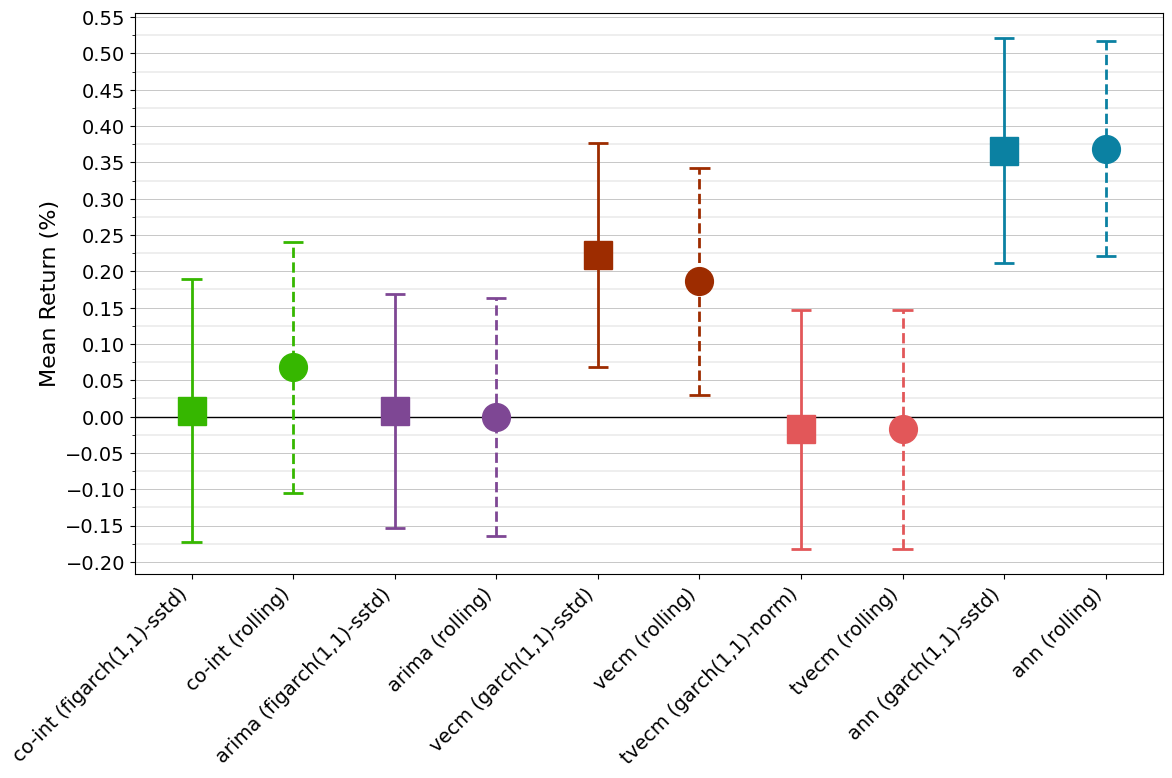

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

pair = 'the - nbp'

plt.rc('font', size=14)  
plt.rc('axes', titlesize=18) 
plt.rc('axes', labelsize=16)  
plt.rc('xtick', labelsize=14)  
plt.rc('ytick', labelsize=14)  
plt.rc('legend', fontsize=14)  

df_plot = filtered_dataframes[pair]

def map_volatility_model(vol_model):
    if 'GARCH' in vol_model:
        if vol_model.startswith('sGARCH'):
            base = 'garch'
        else:
            base = vol_model.split('_')[0].lower()
        
        order = '(2,1)' if '21' in vol_model else '(1,1)'
        
        suffix = '-' + vol_model.split('_')[1] if '_' in vol_model else ''
        
        return f"{base}{order}{suffix}"
    else:
        return vol_model

df_plot['Volatility_model_mapped'] = df_plot['Volatility_model'].apply(map_volatility_model)

def map_model_name(model):
    if model == 'ann':
        return 'ann'
    elif model == 'vecm':
        return 'vecm'
    elif model == 'tvecm_long_t1':
        return 'tvecm'
    elif model == 'ols':
        return 'co-int'
    elif model == 'naive':
        return 'naïve'
    elif model == 'perfect_information':
        return 'perfect'
    else:
        return model

df_plot['Model_mapped'] = df_plot['Model'].apply(map_model_name)


df_plot['models_plot'] = np.where(
    df_plot['Volatility_model_mapped'] == " ",
    df_plot['Model_mapped'],
    df_plot['Model_mapped'] + " (" + df_plot['Volatility_model_mapped'] + ")"
)

means_plot = df_plot['Mean'].astype(float)
ci_lower_err_plot = means_plot - df_plot['Confidence_Interval'].str.split(' ').str[0].str.rstrip('%').astype(float)
ci_upper_err_plot = df_plot['Confidence_Interval'].str.split(' ').str[1].str[1:].str.rstrip('%').astype(float) - means_plot

unique_models = df_plot['models_plot'].str.split(" ").str[0].unique()

colors = ['#36b700', '#7e4794', '#9d2c00', '#e25759', '#0b81a2']

model_colors = {model: colors[i % len(colors)] for i, model in enumerate(unique_models)}

marker_styles = {'GARCH': 's', 'rolling': 'o'}
line_styles = {'GARCH': '-', 'rolling': '--'}
marker_size = 20
lw = 2
cap_width = 0.1

y_major_ticks = np.arange(-0.5, 1.1, 0.05)
y_minor_ticks = np.arange(-0.5, 1.1, 0.025) 

plt.figure(figsize=(12, 8))

plt.yticks(y_major_ticks)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.025)) 

plt.axhline(0, color='black', linewidth=1, linestyle='-')

plt.grid(axis='y', linestyle='-', linewidth=0.5, which='major')
plt.grid(axis='y', linestyle='-', linewidth=0.3, which='minor')

for i, (model, mean, vol_model) in enumerate(zip(df_plot['models_plot'], means_plot, df_plot['Volatility_model_mapped'])):
    base_model = model.split(" ")[0]  # Extract base model name (e.g., 'COINTEGRATION', 'VECM')
    marker = marker_styles['rolling'] if 'rolling' in vol_model else marker_styles['GARCH']
    line_style = line_styles['rolling'] if 'rolling' in vol_model else line_styles['GARCH']
    
    plt.plot(model, mean, marker=marker, color=model_colors[base_model], markersize=marker_size)
    
    plt.vlines(
        model, mean - ci_lower_err_plot.iloc[i], mean + ci_upper_err_plot.iloc[i],
        colors=model_colors[base_model], linestyles=line_style, lw=lw
    )
    
    plt.hlines(
        y=mean - ci_lower_err_plot.iloc[i], xmin=i - cap_width, xmax=i + cap_width,
        colors=model_colors[base_model], linestyles="-", lw = lw
    )
    plt.hlines(
        y=mean + ci_upper_err_plot.iloc[i], xmin=i - cap_width, xmax=i + cap_width,
        colors=model_colors[base_model], linestyles="-", lw = lw
    )


plt.ylabel('Mean Return (%)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [57]:
df_plot

,Model,Pair,Volatility_model,Window_size,Rolling_window,Threshold,Mean,Standard_Deviation,Confidence_Interval,Trade_rate,Cumulative_Return,Volatility_model_mapped,Model_mapped,models_plot
0,ols,the - nbp,fiGARCH_sstd,5,None,0.48,0.008,1.462,-0.173% -0.189%,85.6,0.40,"figarch(1,1)-sstd",co-int,"co-int (figarch(1,1)-sstd)"
0,ols,the - nbp,rolling,5,15,0.93,0.068,1.394,-0.105% -0.240%,82.0,3.40,rolling,co-int,co-int (rolling)
0,arima,the - nbp,fiGARCH_sstd,5,None,0.01,0.008,1.298,-0.153% -0.169%,91.6,0.40,"figarch(1,1)-sstd",arima,"arima (figarch(1,1)-sstd)"
0,arima,the - nbp,rolling,5,5,0.01,-0.001,1.324,-0.165% -0.163%,92.8,-0.05,rolling,arima,arima (rolling)
0,vecm,the - nbp,sGARCH_sstd,5,None,0.04,0.222,1.240,0.068% -0.376%,82.0,11.10,"garch(1,1)-sstd",vecm,"vecm (garch(1,1)-sstd)"
0,vecm,the - nbp,rolling,5,10,0.10,0.186,1.259,0.030% -0.342%,80.8,9.30,rolling,vecm,vecm (rolling)
0,tvecm_long_t1,the - nbp,sGARCH_norm,5,None,0.12,-0.017,1.324,-0.182% -0.147%,92.8,-0.85,"garch(1,1)-norm",tvecm,"tvecm (garch(1,1)-norm)"
0,tvecm_long_t1,the - nbp,rolling,5,55,0.13,-0.017,1.324,-0.182% -0.147%,92.8,-0.85,rolling,tvecm,tvecm (rolling)
0,ann,the - nbp,sGARCH_sstd,5,None,0.06,0.366,1.246,0.212% -0.521%,86.8,18.30,"garch(1,1)-sstd",ann,"ann (garch(1,1)-sstd)"
0,ann,the - nbp,rolling,5,10,0.23,0.369,1.194,0.221% -0.517%,80.4,18.45,rolling,ann,ann (rolling)


In [58]:
from importlib import reload
import trading_system
reload(trading_system)

<module 'trading_system' from '/Users/sindrehaugland/Documents/Master/statistical-arbitrage/trading/trading_system.py'>

Index of maximum return: 227
Index of maximum return: 227
Index of maximum return: 227
Index of maximum return: 227
Index of maximum return: 227
Index of maximum return: 227
Index of maximum return: 24
Index of maximum return: 24
Index of maximum return: 31
Index of maximum return: 31


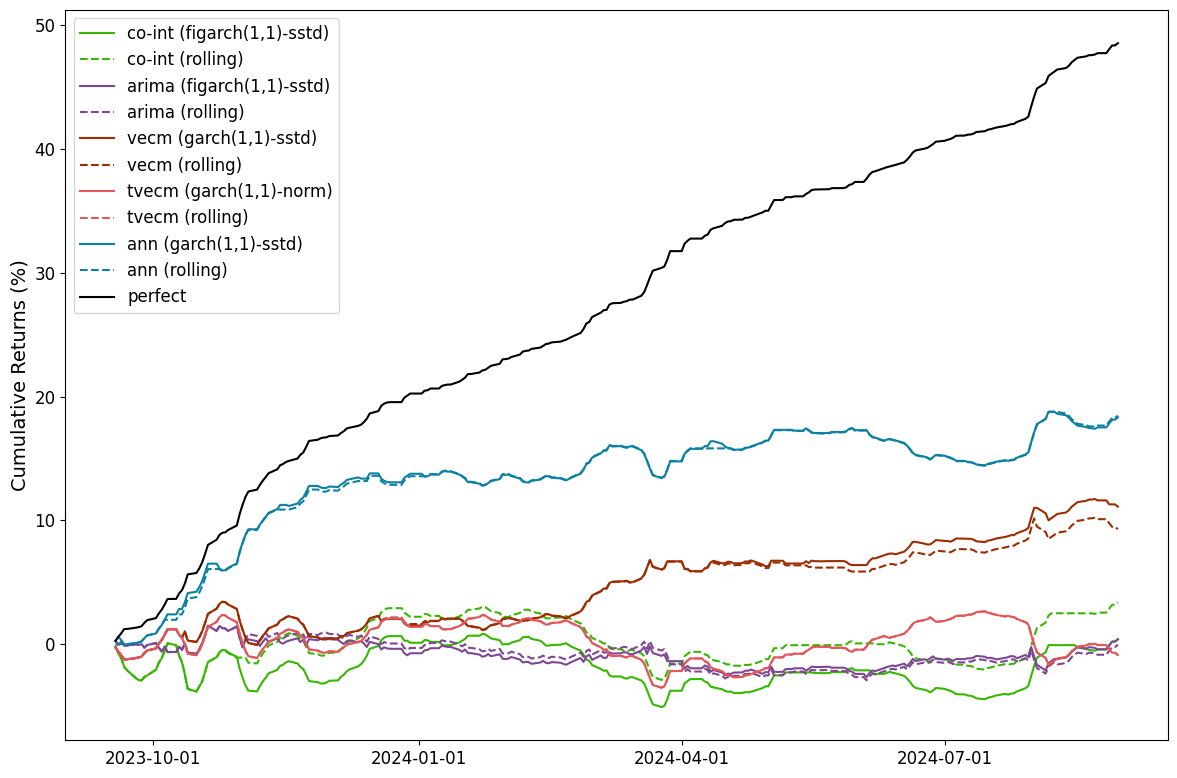

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime



cumulative_returns_dict = {}

for index, row in df_plot.iterrows():
    model = row['Model']
    models_plot = row['models_plot'] 
    rolling_window = row['Rolling_window']
    lower_threshold = row['Threshold']
    vol_model = row['Volatility_model']
    pair = row['Pair']
    hub1_name = pair.split("-")[0].strip()
    hub2_name = pair.split("-")[1].strip()
    
    params = cointegration_params.copy() if model == "ols" else forecasting_params.copy()
    
    params.update({
        "hub1_name": hub1_name,
        "hub2_name": hub2_name,
        "model": model,
        "mode": "test"
    })
    
    test_ts = trading_system.TradingSystem(**params)
    test_ts.run_trading_system(
        volatility=vol_model,
        rolling_window=rolling_window,
        lower_threshold=lower_threshold,
        special_strategy="no",
        verbose=False,
        plot=False
    )

    dates = test_ts.get_dates()
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    returns = np.array(test_ts.returns)*100/5
    
    max_return_idx = np.argmax(returns)
    print("Index of maximum return:", max_return_idx)
    cumulative_returns = np.cumsum(returns)
    
    if models_plot not in cumulative_returns_dict:
        cumulative_returns_dict[models_plot] = {}
    cumulative_returns_dict[models_plot][vol_model] = cumulative_returns



colors = ['#36b700', '#7e4794', '#9d2c00', '#e25759', '#0b81a2', "#000000"]

unique_models = df_plot['models_plot'].unique()
model_colors = {model: colors[i // 2 ] for i, model in enumerate(unique_models)}

plt.figure(figsize=(12, 8))

dates = test_ts.get_dates()
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

for models_plot, vol_models in cumulative_returns_dict.items():
    for vol_model, cumulative_returns in vol_models.items():
        label = f"{models_plot}"
        color = model_colors[models_plot]  # Use consistent colors
        line_style = '--' if vol_model == 'rolling' else '-' 
        plt.plot(dates, cumulative_returns, label=label, color=color, linestyle=line_style)

if True:
    test_ts.run_trading_system(
            volatility=vol_model,
            rolling_window=rolling_window,
            lower_threshold=100,
            special_strategy="perfect_information",
            verbose=False,
            plot=False
        )
    returns = np.array(test_ts.returns)*100/5
    cumulative_returns = np.cumsum(returns)

    plt.plot(dates, cumulative_returns, label="perfect", color="black", linestyle='-')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=5))

plt.ylabel("Cumulative Returns (%)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.grid(False)

plt.tight_layout()

plt.show()
